# Variance of SAXS data

There has been a long discussion about the validity (or not) of pixel splitting regarding the propagation of errors [#520](https://github.com/silx-kit/pyFAI/issues/520) [#882](https://github.com/silx-kit/pyFAI/issues/882) [#883](https://github.com/silx-kit/pyFAI/issues/883).
So we will develop a mathematical model for a SAXS experiment and validate it in the case of a SAXS approximation (i.e. no solid-angle correction, no polarisation effect, and of course small angled $\theta = sin(\theta) = tan(\theta)$)

## System under study

Let's do a numerical experiment, simulating the following experiment:

* Detector: 1024x1024 square pixels of 100µm each, assumed to be poissonian. 
* Geometry: The detector is placed at 1m from the sample, the beam center is in the corner of the detector
* Intensity: the maximum signal on the detector is 10 000 photons per pixel, each pixel having a minimum count of a hundreed.
* Wavelength: 1 Angstrom
* During the first part of the studdy, the solid-angle correction will be discarded, same for polarisation corrections.
* Since pixel splitting is disabled, many rebinning engines are available and will be benchmarked:
  - numpy: the slowest available in pyFAI
  - histogram: implemented in cython
  - nosplit_csr: using a look-up table
  - nosplit_csr_ocl_gpu: which offloads the calculation on the GPU.
  
  We will check they all provide the same numerical result
  
Now we define some constants for the studdy. The dictionary *kwarg* contains the parameters used for azimuthal integration. This ensures the number of bins for the regrouping or correction like $\Omega$ and polarization are always the same.

In [1]:
%matplotlib inline
# use `widget` instead of `inline` for better user-exeperience. `inline` allows to store plots into notebooks.
import time
start_time = time.perf_counter()
import sys
print(sys.executable)
print(sys.version)
import os
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "0"

/users/edgar1993a/kk/bin/python
3.11.5 (main, Sep 11 2023, 13:54:46) [GCC 11.2.0]


In [2]:
pix = 100e-6
shape = (1024, 1024)
npt = 1000 
nimg = 1000
wl = 1e-10
I0 = 1e4
kwargs = {"npt":npt, 
         "correctSolidAngle":False, 
         "polarization_factor":None,
         "safe":False}


In [3]:
import numpy
from scipy.stats import chi2 as chi2_dist
from matplotlib.pyplot import subplots
from matplotlib.colors import LogNorm
import logging
logging.basicConfig(level=logging.ERROR)
import pyFAI
print(f"pyFAI version: {pyFAI.version}")
from pyFAI.detectors import Detector
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
from pyFAI.method_registry import IntegrationMethod
from pyFAI.gui import jupyter
detector = Detector(pix, pix)
detector.shape = detector.max_shape = shape
print(detector)

pyFAI version: 2024.1.0-rc0
Detector Detector	 PixelSize= 1.000e-04, 1.000e-04 m	 BottomRight (3)


We define in *ai_init* the geometry, the detector and the wavelength. 

In [4]:
ai_init = {"dist":1.0, 
           "poni1":0.0, 
           "poni2":0.0, 
           "rot1":0.0,
           "rot2":0.0,
           "rot3":0.0,
           "detector":detector, 
           "wavelength":wl}
ai = AzimuthalIntegrator(**ai_init)
print(ai)          

#Solid consideration:
Ω  = ai.solidAngleArray(detector.shape, absolute=True)

print("Solid angle: maxi= {} mini= {}, ratio= {}".format(Ω.max(), Ω.min(), Ω.min()/Ω.max()))

Detector Detector	 PixelSize= 1.000e-04, 1.000e-04 m	 BottomRight (3)
Wavelength= 1.000000e-10 m
SampleDetDist= 1.000000e+00 m	PONI= 0.000000e+00, 0.000000e+00 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 1000.000 mm	Center: x=0.000, y=0.000 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 1.000Å
Solid angle: maxi= 9.999999925000007e-09 mini= 9.69376805173843e-09, ratio= 0.9693768124441684


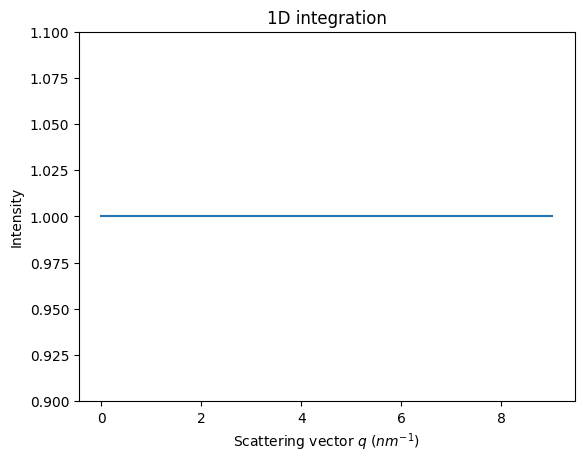

In [5]:
# Validation of the flatness of a flat image integrated
flat = numpy.ones(detector.shape)
res_flat = ai.integrate1d(flat, **kwargs)
crv = jupyter.plot1d(res_flat)
crv.axes.set_ylim(0.9,1.1)
pass

In [6]:
#Equivalence of different rebinning engines ... looking for the fastest:
fastest = sys.maxsize
best = None
print(f"| {'Method':70s} | {'error':8s} | {'time(ms)':7s}|")
print("+"+"-"*72+"+"+"-"*10+"+"+"-"*9+"+")
for method in IntegrationMethod.select_method(dim=1):
    res_flat = ai.integrate1d(flat, method=method, **kwargs)
    #print(f"timeit for {method} max error: {abs(res_flat.intensity-1).max()}")
    m = str(method).replace(")","")[26:96]
    err = abs(res_flat.intensity-1).max()
    
    tm = %timeit -o -r1 -q ai.integrate1d(flat, method=method, **kwargs)
    tm_best = tm.best
    print(f"| {m:70s} | {err:6.2e} | {tm_best*1000:7.3f} |")
    if tm_best<fastest:
        fastest = tm_best
        best = method
print("+"+"-"*72+"+"+"-"*10+"+"+"-"*9+"+")
print(f"\nThe fastest method is {best} in {1000*fastest:.3f} ms/1Mpix frame")

| Method                                                                 | error    | time(ms)|
+------------------------------------------------------------------------+----------+---------+
| no split, histogram, python                                            | 0.00e+00 |  51.164 |
| no split, histogram, cython                                            | 0.00e+00 |  21.470 |
| bbox split, histogram, cython                                          | 0.00e+00 |  30.718 |
| full split, histogram, cython                                          | 0.00e+00 | 206.269 |
| no split, CSR, cython                                                  | 0.00e+00 |  18.834 |
| bbox split, CSR, cython                                                | 0.00e+00 |  15.741 |
| no split, CSR, python                                                  | 0.00e+00 |  16.279 |
| bbox split, CSR, python                                                | 0.00e+00 |  18.182 |
| no split, CSC, cython                 

In [6]:
# so we chose the fastest method without pixel splitting ...other methods may be faster
kwargs["method"] = IntegrationMethod.select_method(dim=1, 
                                                  split="no", 
                                                  algo="csr", 
                                                  impl="opencl",
                                                  target_type="gpu")[-1]
print(kwargs["method"])

IntegrationMethod(1d int, no split, CSR, OpenCL, NVIDIA CUDA / NVIDIA RTX A2000 12GB)


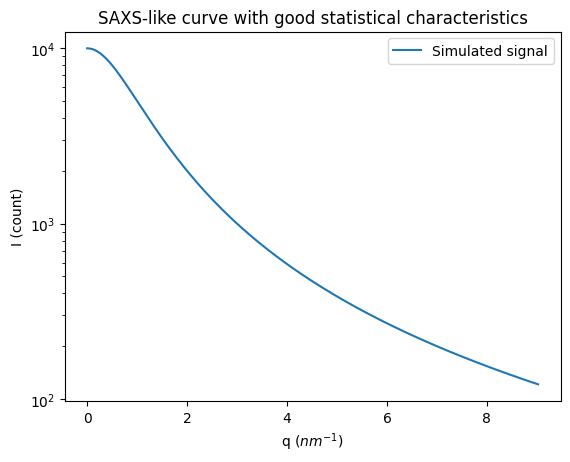

In [7]:
# Generation of a "SAXS-like" curve with the shape of a lorentzian curve

q = numpy.linspace(0, res_flat.radial.max(), npt)
I = I0/(1+q**2)
fig, ax = subplots()
ax.semilogy(q, I, label="Simulated signal")
ax.set_xlabel("q ($nm^{-1}$)")
ax.set_ylabel("I (count)")
ax.set_title("SAXS-like curve with good statistical characteristics")
ax.legend()
pass

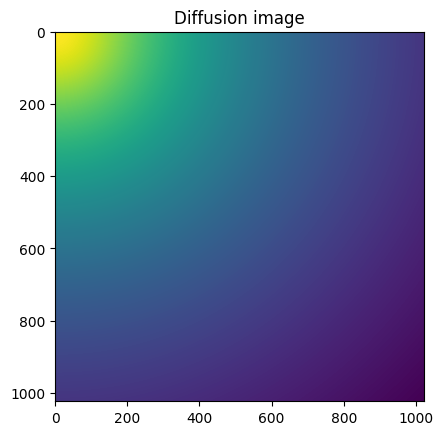

In [8]:
#Reconstruction of diffusion image:

img_theo = ai.calcfrom1d(q, I, dim1_unit="q_nm^-1", 
                         correctSolidAngle=False, 
                         polarization_factor=None)
fig, ax = subplots()
ax.imshow(img_theo, norm=LogNorm())
ax.set_title("Diffusion image")
pass

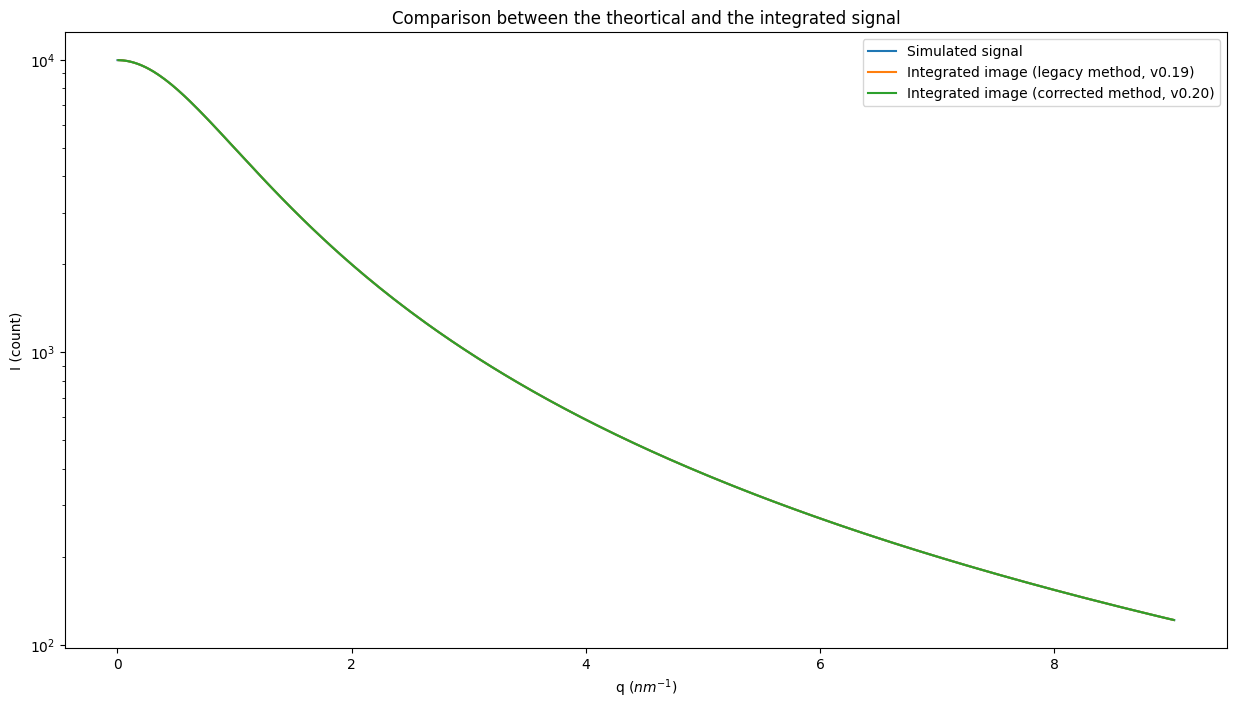

In [9]:
fig, ax = subplots(figsize=(15,8))
ax.semilogy(q, I, label="Simulated signal")
ax.set_xlabel("q ($nm^{-1}$)")
ax.set_ylabel("I (count)")
res_ng = ai.integrate1d_ng(img_theo, **kwargs)
res_legacy = ai.integrate1d_legacy(img_theo, **kwargs)
ax.plot(*res_legacy, label="Integrated image (legacy method, v0.19)")
ax.plot(*res_ng, label="Integrated image (corrected method, v0.20)")
ax.set_title("Comparison between the theortical and the integrated signal")
#Display the error: commented as it makes the graph less readable
#I_bins = I0/(1+res.radial**2)
#ax.plot(res.radial, abs(res.intensity-I_bins), label="error")
ax.legend()
pass

## Construction of a synthetic dataset

We construct now a synthetic dataset of thousand images of this reference image with a statistical distribution which is common for photon-counting detectors (like Pilatus or Eiger): The Poisson distribution. The signal is between 100 and 10000, so every pixel should see photons and there is should be no "rare-events" bias (which sometimes occures in SAXS).

### Poisson distribution:
The Poisson distribution has the peculiarity of having its variance equal to the signal, hence the standard deviation equals to the square root of the signal. 


**Nota:** the generation of the images is slow and takes about 1Gbyte of memory !


In [10]:
%%time

if "dataset" not in dir():
    dataset = numpy.random.poisson(img_theo, (nimg,) + img_theo.shape)
# else avoid wasting time
print(dataset.nbytes/(1<<20), "MBytes", dataset.shape)

8000.0 MBytes (1000, 1024, 1024)
CPU times: user 50.2 s, sys: 1.62 s, total: 51.8 s
Wall time: 51.9 s


### Validation of the Poisson distribution.

We have now thousand images of one magapixel. It is interesting to validate if the distribution actually follows the Poisson distribution. For this we will check if the *signal* and its *variance* follow a $\chi^2$ distribution. 

For every pair of images I and J we calculate the numerical value of $\chi ^2$:

$$
\chi^2 = \frac{1}{nbpixel-1}\sum_{pix}\frac{(I_{pix} - J_{pix})^2}{\sigma(I_{pix})^2 + \sigma(J_{pix})^2)}
$$

The distibution is obtained by calculating the histogram of $\chi^2$ values for every pair of images, here almost half a milion. 

The calculation of the $\chi^2$ value is likely to be critical in time, so we will shortly investigate 3 implementation: *numpy* (fail-safe but not that fast), *numexp* and *numba*
Do not worry if any of the two later method fail: they are faster but provide the same numerical result as numpy.

In [11]:
print("Number of paires of images: ", nimg*(nimg-1)//2)

Number of paires of images:  499500


In [12]:
#Numpy implementation of Chi^2 measurement for a pair of images. Fail-safe implementation

def chi2_images_np(I, J):
    """Calculate the Chi2 value for a pair of images with poissonnian noise 
    Numpy implementation"""
    return ((I-J)**2/(I+J)).sum()/(I.size - 1)

img0 = dataset[0]
img1 = dataset[1]
print("𝜒² value calculated from numpy on the first pair of images:", chi2_images_np(img0, img1))
%timeit chi2_images_np(img0, img1)

𝜒² value calculated from numpy on the first pair of images: 0.9992004517615287
7.29 ms ± 342 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
#Numexp implementation of Chi^2 measurement for a pair of images. 
import numexpr
from numexpr import NumExpr
expr = NumExpr("((I-J)**2/(I+J))", signature=[("I", numpy.float64),("J", numpy.float64)])

def chi2_images_ne(I, J):
    """Calculate the Chi2 value for a pair of images with poissonnian noise
    NumExpr implementation"""
    return expr(I, J).sum()/(I.size-1)

img0 = dataset[0]
img1 = dataset[1]
print("𝜒² value calculated from numexpr on the first pair of images:",chi2_images_ne(img0, img1))
for i in range(6):
    j = 1<<i 
    numexpr.set_num_threads(j)
    print(f"Timing when using {j} threads: ")
    %timeit -r 3 chi2_images_ne(img0, img1)

#May fail if numexpr is not installed, but gives the same numerical value, just faster

𝜒² value calculated from numexpr on the first pair of images: 0.9992004517615287
Timing when using 1 threads: 
5.05 ms ± 215 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
Timing when using 2 threads: 
3.97 ms ± 60.5 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
Timing when using 4 threads: 
2.58 ms ± 92.4 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
Timing when using 8 threads: 
2.07 ms ± 34.9 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
Timing when using 16 threads: 
2.19 ms ± 115 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
Timing when using 32 threads: 
2.32 ms ± 55.5 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


In [14]:
#Numba implementation of Chi^2 measurement for a pair of images. 
from numba import jit, njit, prange

@njit(parallel=True)
def chi2_images_nu(img1, img2):
    """Calculate the Chi2 value for a pair of images with poissonnian noise
    Numba implementation"""
    I = img1.ravel()
    J = img2.ravel()
    l = len(I)
    #assert len(J) == l
    #version optimized for JIT
    s = 0.0
    for i in prange(len(I)):
        a = float(I[i])
        b = float(J[i])
        s+= (a-b)**2/(a+b)
    return s/(l-1)

img0 = dataset[0]
img1 = dataset[1]
print("𝜒² value calculated from numba on the first pair of images:", chi2_images_nu(img0, img1))
%timeit chi2_images_nu(img0, img1)

#May fail if numba is not installed. 
# The numerical value, may differ due to reduction algorithm used, should be the fastest.

𝜒² value calculated from numba on the first pair of images: 0.9992004517615325
631 µs ± 18.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [15]:
# Select the prefered algorithm for calculating the numerical value of chi^2 for a pair of images.
chi2_images = chi2_images_ne
numexpr.set_num_threads(16)

32

In [16]:
%%time 

#Calculate the numerical value for chi2 for every pair of images. This takes a while

c2i = []
for i in range(nimg):
    img1 = dataset[i]
    for img2 in dataset[:i]:
        c2i.append(chi2_images(img1, img2))
c2i = numpy.array(c2i)

CPU times: user 2h 26min 21s, sys: 3min 7s, total: 2h 29min 29s
Wall time: 21min 46s


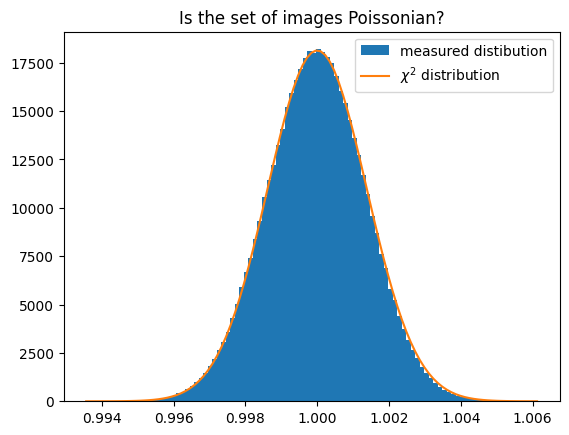

In [17]:
fig, ax = subplots()
h,b,_ = ax.hist(c2i, 100, label="measured distibution")
ax.plot()
size = numpy.prod(shape)
y_sim = chi2_dist.pdf(b*(size-1), size)
y_sim *= h.sum()/y_sim.sum()
ax.plot(b, y_sim, label=r"$\chi^2$ distribution")
ax.set_title("Is the set of images Poissonian?")
ax.legend()
pass

This validates the fact that our set of image is actually a Poissonian distribution around the target image displayed in figure 3.

## Integration of images in the SAXS appoximation:

We can now integrate all images and check wheather all pairs of curves (with their associated error) fit or not the $\chi^2$ distribution. 

It is important to remind that we stay in SAXS approximation, i.e. no solid angle correction or other position-dependent normalization. The pixel splitting is also disabled. So the azimuthal integration is simply:

$$
I_{bin} = \frac{1}{count(pix\in bin)} \sum_{pix \in bin} I_{pix}
$$

The number of bins in the curve being much smaller than the number of pixel in the input image, this calculation is less time-critical. So we simply define the same kind of $\chi^2$ function using numpy.

In [18]:
def chi2_curves(res1, res2):
    """Calculate the Chi2 value for a pair of integrated data"""
    I = res1.intensity
    J = res2.intensity
    l = len(I)
    assert len(J) == l
    sigma_I = res1.sigma
    sigma_J = res2.sigma
    return ((I-J)**2/(sigma_I**2+sigma_J**2)).sum()/(l-1)

In [19]:
%%time
#Perform the azimuthal integration of every single image

integrated = [ai.integrate1d_legacy(data, variance=data, **kwargs)
             for data in dataset]

CPU times: user 4.72 s, sys: 6.94 ms, total: 4.73 s
Wall time: 4.73 s


In [20]:
#Check if chi^2 calculation is time-critical:
%timeit chi2_curves(integrated[0], integrated[1])

11.7 µs ± 185 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [21]:
%%time 
c2 = []
for i in range(nimg):
    res1 = integrated[i]
    for res2 in integrated[:i]:
        c2.append(chi2_curves(res1, res2))
c2 = numpy.array(c2)

CPU times: user 6.31 s, sys: 0 ns, total: 6.31 s
Wall time: 6.32 s


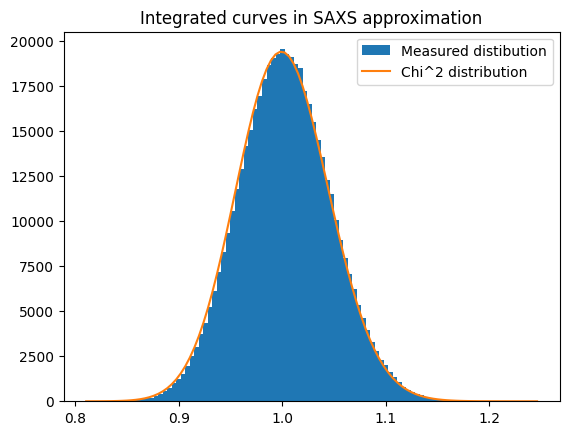

In [22]:
fig, ax = subplots()
h,b,_ = ax.hist(c2, 100, label="Measured distibution")
y_sim = chi2_dist.pdf(b*(npt-1), npt)
y_sim *= h.sum()/y_sim.sum()
ax.plot(b, y_sim, label=r"Chi^2 distribution")
ax.set_title("Integrated curves in SAXS approximation")
ax.legend()
pass

In [23]:
low_lim, up_lim = chi2_dist.ppf([0.005, 0.995], nimg) / (nimg - 1)
print(low_lim, up_lim)
print("Expected outliers: ", nimg*(nimg-1)*0.005/2, "got", 
(c2<low_lim).sum(),"below and ",(c2>up_lim).sum(), "above")

0.889452976157626 1.1200681344576493
Expected outliers:  2497.5 got 2121 below and  2882 above


## Integration of images with solid angle correction/polarization correction

PyFAI applies by default solid-angle correction which is needed for powder diffraction. 
On synchrotron sources, the beam is highly polarized and one would like to correct for this effect as well. How does it influence the error propagation ? 

If we enable the solid angle normalisation (noted $\Omega$) and the polarisation correction (noted $P$), this leads us to:

$$
I_{bin} = \frac{1}{count(pix\in bin)} \sum_{pix \in bin} \frac{I_{pix}}{\Omega_{pix} P_{pix}}
$$

Flatfield correction and any other normalization like pixel efficiency related to sensor thickness should be accounted in the same way.

**Nota:** The pixel splitting remains disabled. 

IntegrationMethod(1d int, no split, CSR, OpenCL, NVIDIA CUDA / NVIDIA RTX A2000 12GB)


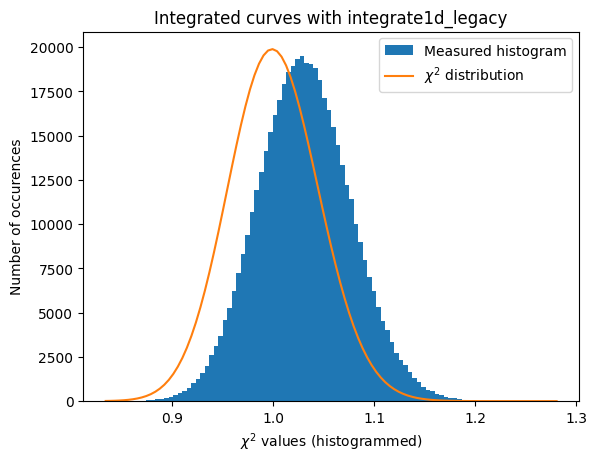

In [25]:
kwargs = {"npt":npt, 
          "correctSolidAngle": True, 
          "polarization_factor": 0.9,
          "error_model": "poisson", 
          "safe":False}
kwargs["method"] = IntegrationMethod.select_method(dim=1, 
                                                  split="no", 
                                                  algo="csr", 
                                                  impl="opencl",
                                                  target_type="gpu")[-1]
print(kwargs["method"])
# Since  we use "safe"=False, we need to reset the integrator manually:
ai.reset()

def plot_distribution(ai, kwargs, nbins=100, integrate=None, ax=None):
    ai.reset()
    results = []
    c2 = []
    if integrate is None:
        integrate = ai._integrate1d_legacy
    for i in range(nimg):
        data = dataset[i, :, :]
        r = integrate(data, **kwargs)
        results.append(r)    
        for j in results[:i]:
            c2.append(chi2_curves(r, j))
    c2 = numpy.array(c2)
    if ax is None:
        fig, ax = subplots()
    h,b,_ = ax.hist(c2, nbins, label="Measured histogram")
    y_sim = chi2_dist.pdf(b*(npt-1), npt)
    y_sim *= h.sum()/y_sim.sum()
    ax.plot(b, y_sim, label=r"$\chi^{2}$ distribution")
    ax.set_title(f"Integrated curves with {integrate.__name__}")
    ax.set_xlabel("$\chi^{2}$ values (histogrammed)")
    ax.set_ylabel("Number of occurences")
    ax.legend()
    return ax

a=plot_distribution(ai, kwargs)

The normalisation of the raw signal distorts the distribution of error, even at a level of a few percent correction ! (Thanks Daniel Franke for the demonstration)

## Introducing the *new generation* of azimuthal integrator ... in production since 0.20

As any normalization introduces some distortion into the error propagation, the error propagation should properly account for this. Alessandro Mirone suggested to treat normalization within azimuthal integration like this :

$$
I_{bin} = \frac{\sum_{pix \in bin} I_{pix}}{\sum_{pix \in bin} \Omega_{pix}P_{pix}}
$$

This is under investigation since begining 2017 https://github.com/silx-kit/pyFAI/issues/520 and is now available in production.

**Nota:**
This is a major issue as almost any commercial detector comes with flatfield correction already applied on raw images; making impossible to properly propagate the error (I am especially thinking at photon counting detectors manufactured by Dectris!). The detector should then provide the actual raw-signal and the flatfield normalization to allow proper signal and error propagation.

Here is a comparison between the *legacy* integrators and the *new generation* ones:

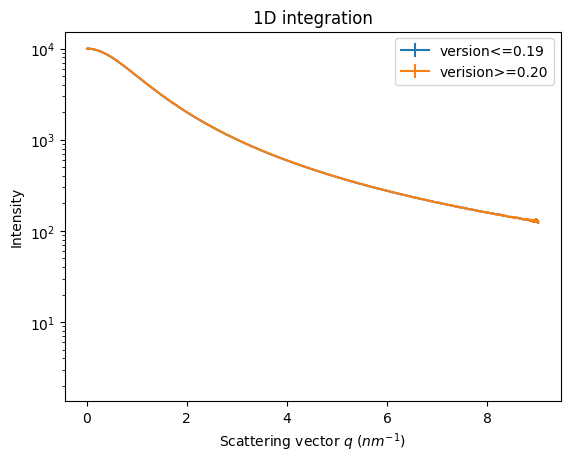

In [26]:
#The new implementation provides almost the same result as the former one:
ai.reset()
fig, ax = subplots()
data = dataset[0]
ax.set_yscale("log")
jupyter.plot1d(ai.integrate1d_legacy(data, **kwargs), ax=ax, label="version<=0.19")
jupyter.plot1d(ai.integrate1d_ng(data, **kwargs), ax=ax, label="verision>=0.20")
ax.legend()
pass
# If you zoom in enough, you will see the difference !

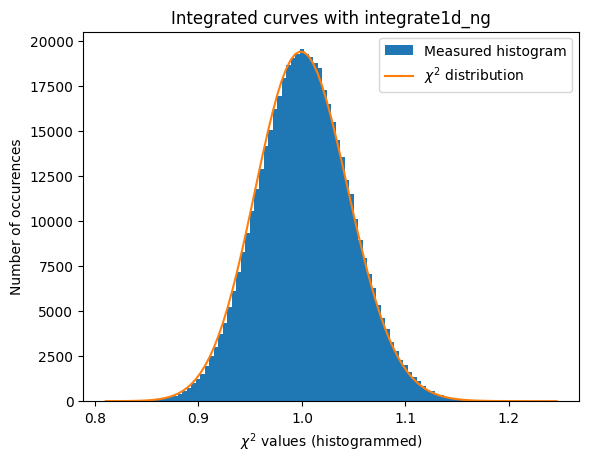

In [27]:
#Validation of the error propagation without pixel splitting but with normalization:
a=plot_distribution(ai, kwargs, integrate = ai.integrate1d_ng)

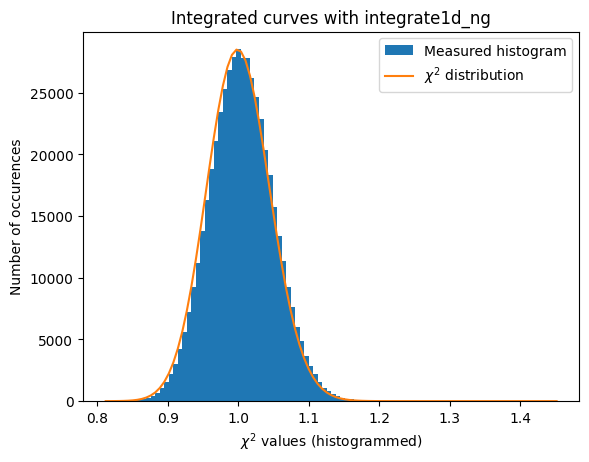

In [28]:
#Validation of the error propagation without pixel splitting with azimuthal error assessement
kw_azim = kwargs.copy()
kw_azim["error_model"] = "azimuthal"
kw_azim["correctSolidAngle"] = False
kw_azim["polarization_factor"] = None


a=plot_distribution(ai, kw_azim, integrate = ai.integrate1d_ng)

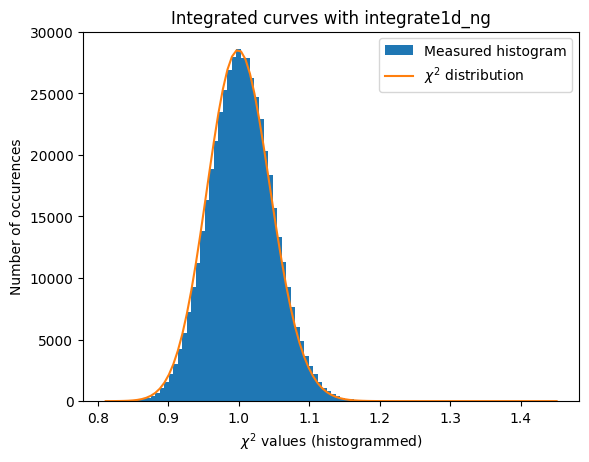

In [29]:
#what if we use weights (solid-angle, polarization, ...) together with azimuthal error assessement ?
#Validation of the error propagation without pixel splitting with azimuthal error assessement
kw_azim = kwargs.copy()
kw_azim["error_model"] = "azimuthal"
kw_azim["correctSolidAngle"] = True
kw_azim["polarization_factor"] = 0.95


a=plot_distribution(ai, kw_azim, integrate = ai.integrate1d_ng)

The azimuthal error model is not correct yet ... work needs to go on in that direction.

## Azimuthal integration with pixel splitting

Pixels splitting is implemented in pyFAI in calculating the fraction of area every pixel spends in any bin. This is noted $c^{pix}_{bin}$. The calculation of those coeficient is done with some simple geometry but it is rather tedious, this is why two implementation exists: a simple one which assues pixels boundary are paralle to the radial and azimuthal axes called ```bbox``` for bounding box and a more precise one calculating the intersection of polygons (called ```full```. The calculation of those coefficient is what lasts during the initialization of the integrator as this piece of code is not (yet) parallelized. The total number of (complete) pixel in a bin is then simply the sum of all those coeficients: $\sum_{pix \in bin} c^{pix}_{bin}$.

The azimuthal integration used to be implemented as (pyFAI <=0.15):

$$
I_{bin} = \frac{ \sum_{pix \in bin} c^{pix}_{bin} \frac{I_{pix}}{\Omega_{pix} P_{pix}}}{\sum_{pix \in bin}c^{pix}_{bin}}
$$

With the associated error propagation (with the error!):

$$
\sigma_{bin} = \frac{\sqrt{\sum_{pix \in bin} c^{pix}_{bin} \sigma^2_{pix}}}{\sum_{pix \in bin}c^{pix}_{bin}}
$$


The *new generation* of integrator in production since version 0.20 (in 1D at least) are implemented like this:

$$
I_{bin} = \frac{\sum_{pix \in bin} c^{pix}_{bin}I_{pix}}{\sum_{pix \in bin} c^{pix}_{bin}\Omega_{pix}P_{pix}}
$$

the associated variance propagation should look like this: 

$$
\sigma_{bin} = \frac{\sqrt{\sum_{pix \in bin} (c^{pix}_{bin})^2 \sigma^2_{pix}}}
                     {\sum_{pix \in bin}c^{pix}_{bin}\Omega_{pix}P_{pix}}
$$

Since we have now tools to validate the error propagation for every single rebinning engine. Let's see if pixel splitting induces some error, with coarse or fine pixel splitting:

IntegrationMethod(1d int, bbox split, CSR, OpenCL, NVIDIA CUDA / NVIDIA RTX A2000 12GB)


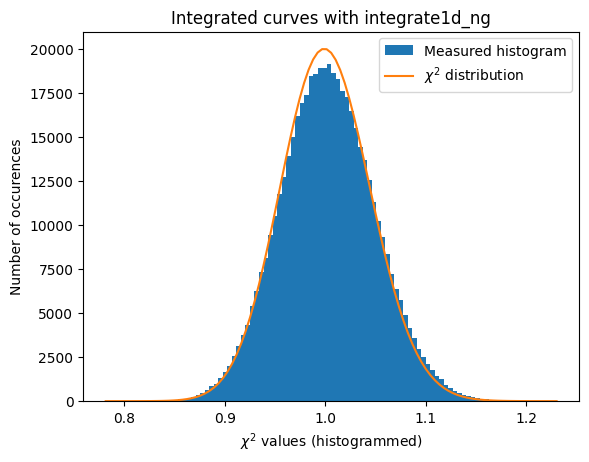

In [31]:
#With coarse pixel-splitting, new integrator:
kwargs["method"] = IntegrationMethod.select_method(dim=1, 
                                                   split="bbox", 
                                                   algo="csr", 
                                                   impl="opencl",
                                                   target_type="gpu")[-1]
print(kwargs["method"])
a = plot_distribution(ai, kwargs, integrate = ai.integrate1d_ng)

IntegrationMethod(1d int, full split, CSR, OpenCL, NVIDIA CUDA / NVIDIA RTX A2000 12GB)


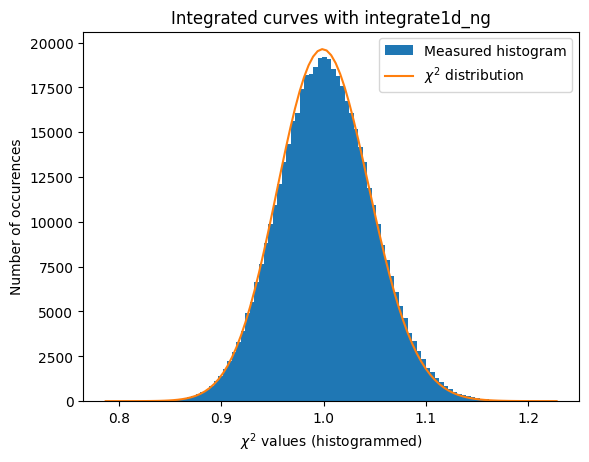

In [32]:
#With fine pixel-splitting, new integrator:
# so we chose the nosplit_csr_ocl_gpu, other methods may be faster depending on the computer
kwargs["method"] = IntegrationMethod.select_method(dim=1, 
                                                   split="full", 
                                                   algo="csr", 
                                                   impl="opencl",
                                                   target_type="gpu")[-1]
print(kwargs["method"])
a = plot_distribution(ai, kwargs, integrate = ai.integrate1d_ng)

With those modification available, we are now able to estimate the error propagated from one curve and compare it with the "usual" result from pyFAI:

The integrated curves are now following the $\chi^2$ distribution, which means that the errors provided are in accordance with the data.

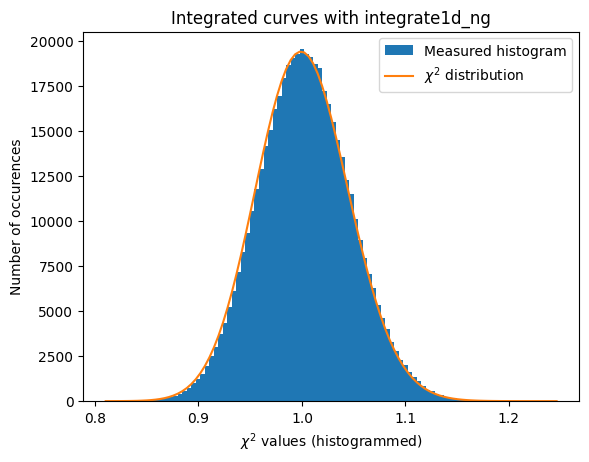

In [33]:
# Python histogramming without pixels splitting.

kwargs = {"npt":npt, 
          "method": ("no", "histogram", "python"),
          "correctSolidAngle": True, 
          "polarization_factor": 0.9,
          "safe": False,
          "error_model": "poisson"}
a = plot_distribution(ai, kwargs, integrate=ai._integrate1d_ng)

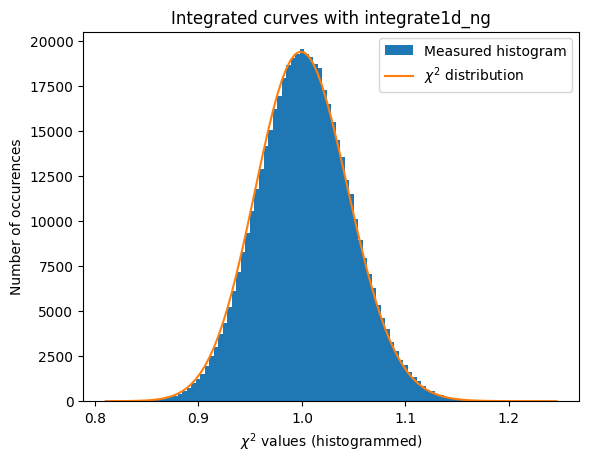

In [34]:
# Cython histogramming without pixels splitting.

kwargs = {"npt":npt, 
          "method": ("no", "histogram", "cython"),
          "correctSolidAngle": True, 
          "polarization_factor": 0.9,
          "safe": False,
          "error_model": "poisson"}
a = plot_distribution(ai, kwargs, integrate=ai._integrate1d_ng)

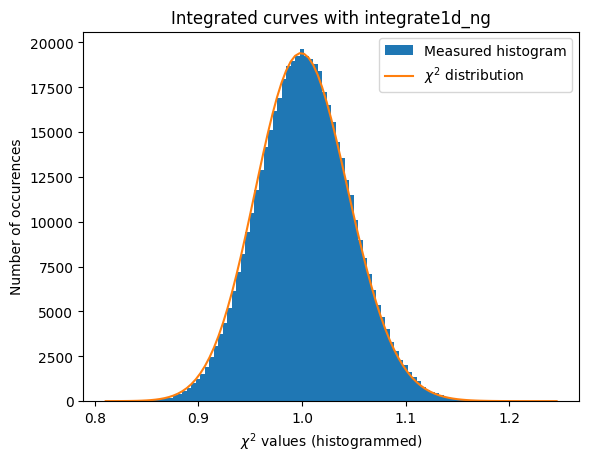

In [35]:
# OpenCL histogramming without pixels splitting.

kwargs = {"npt":npt, 
         "method": ("no", "histogram", "opencl"),
         "correctSolidAngle": True, 
         "polarization_factor": 0.9,
         "safe": False,
         "error_model": "poisson"}
a = plot_distribution(ai, kwargs, integrate=ai._integrate1d_ng)

## Conclusion

PyFAI's historical version (version <=0.16) has been providing proper error propagation ONLY in the case where any normalization (solid angle, flatfield, polarization, ...) and pixel splitting was DISABLED. 
This notebook demonstrates the correctness of the new integrator.
Moreover the fact the normalization is performed as part of the integration is a major issue as almost any commercial detector comes with flatfield correction already applied.

In [36]:
print(f"Total execution time: {time.perf_counter()-start_time:.3f} s")

Total execution time: 1624.837 s
